In [1]:
from logging import warning
# Hücre 1: Kütüphaneleri içe aktar
from logging import warning
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score,f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")


In [2]:
Dataset = pd.read_csv('credit_risk_dataset.csv') #datasetimizi Yükledik
Dataset.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
Dataset.shape

(32581, 12)

In [4]:
Dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


In [5]:
#eksik değerlere bakıyoruz
Dataset.isnull().sum()


person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

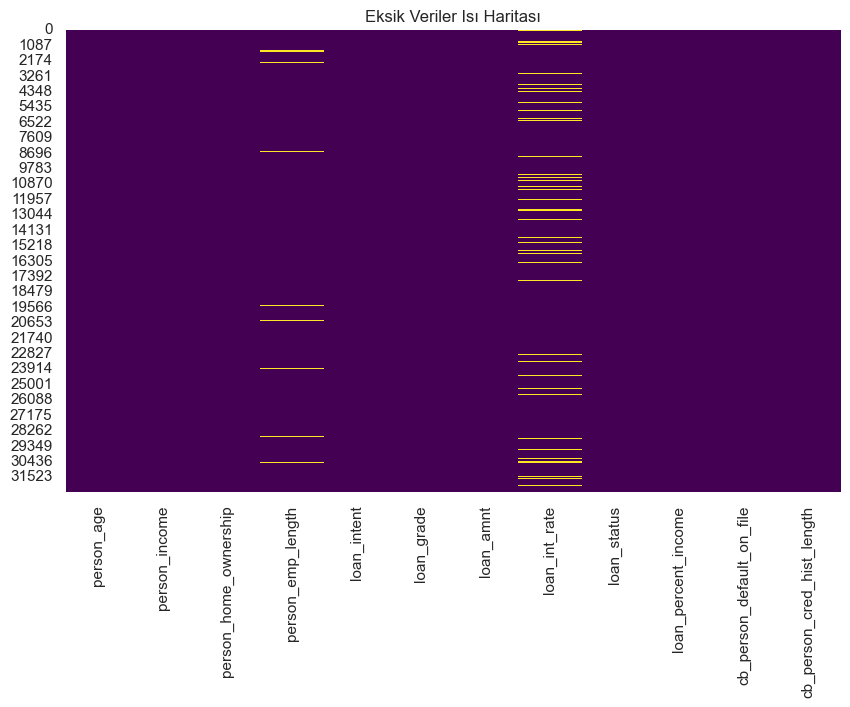

In [6]:
plt.figure(figsize=(10,6))
sns.heatmap(Dataset.isnull(), cbar=False, cmap='viridis')
plt.title('Eksik Veriler Isı Haritası')
plt.show()

In [7]:
#eksik Değerleri ortalamayla dolduruyoruz veri kaybını engellemek için
Person_emp_length_average = Dataset['person_emp_length'].mean()
Dataset['person_emp_length'].fillna(Person_emp_length_average, inplace = True)

loan_int_rate = Dataset["loan_int_rate"].mean()
Dataset["loan_int_rate"].fillna(loan_int_rate, inplace = True)
Dataset.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

### Eksik Verilerin Görselleştirilmesi

In [8]:
#Kategorik değerleri bir yerde topladık
categorical_cols = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']

### Kategorik Değişkenlerin Dağılımı

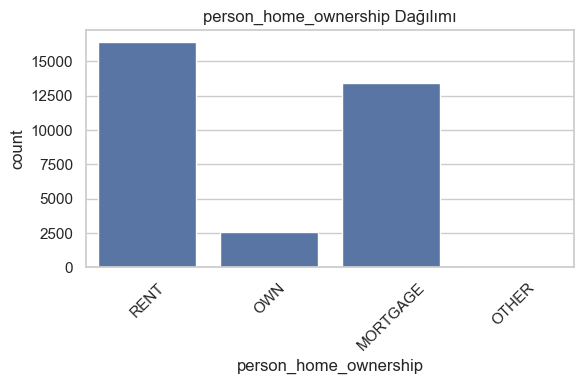

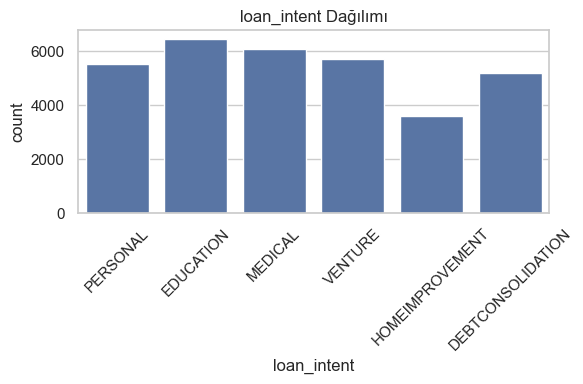

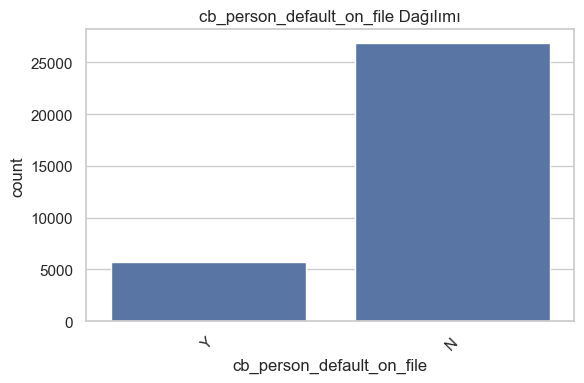

In [9]:
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=Dataset, x=col)
    plt.title(f'{col} Dağılımı')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [10]:
#Datasetimiz one-hot encoding yöntemi ile sayısal değerlere Dönüştürüldü
Dataset = pd.get_dummies(Dataset, columns=categorical_cols, drop_first=True)
bool_cols = Dataset.select_dtypes(include='bool').columns
Dataset[bool_cols] = Dataset[bool_cols].astype(int)
Dataset.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
0,22,59000,123.0,D,35000,16.02,1,0.59,3,0,0,1,0,0,0,1,0,1
1,21,9600,5.0,B,1000,11.14,0,0.10,2,0,1,0,1,0,0,0,0,0
2,25,9600,1.0,C,5500,12.87,1,0.57,3,0,0,0,0,0,1,0,0,0
3,23,65500,4.0,C,35000,15.23,1,0.53,2,0,0,1,0,0,1,0,0,0
4,24,54400,8.0,C,35000,14.27,1,0.55,4,0,0,1,0,0,1,0,0,1


In [11]:
mapping = {
    "G": 0,
    "F": 1,
    "E": 2,
    "D": 3,
    "C": 4,
    "B": 5,
    "A": 6
}
Dataset["loan_grade"] = Dataset["loan_grade"].map(mapping)

In [12]:
#Gelir vb. değişkenlerde yüksek değerlere çok fazla anlam yüklenmemesi için
#normalizasyon ile 0-1 arasına getirdik değerleri
Normalization_Columns = ["person_income","person_age","loan_amnt","loan_int_rate","person_emp_length"]
scaler = MinMaxScaler()

Dataset[Normalization_Columns] = scaler.fit_transform(Dataset[Normalization_Columns])
Dataset.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
0,0.016129,0.009173,1.000000,3,1.000000,0.595506,1,0.59,3,0,0,1,0,0,0,1,0,1
1,0.008065,0.000934,0.040650,5,0.014493,0.321348,0,0.10,2,0,1,0,1,0,0,0,0,0
2,0.040323,0.000934,0.008130,4,0.144928,0.418539,1,0.57,3,0,0,0,0,0,1,0,0,0
3,0.024194,0.010257,0.032520,4,1.000000,0.551124,1,0.53,2,0,0,1,0,0,1,0,0,0
4,0.032258,0.008406,0.065041,4,1.000000,0.497191,1,0.55,4,0,0,1,0,0,1,0,0,1


In [13]:
#X bağımsız Y ise bağımlı değişken olarak ayırdık
X = Dataset.drop('loan_status', axis=1)
y = Dataset['loan_status']

In [14]:
#0.2 test 0.8 train olarak verimizi ayırdık
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(26064, 17)

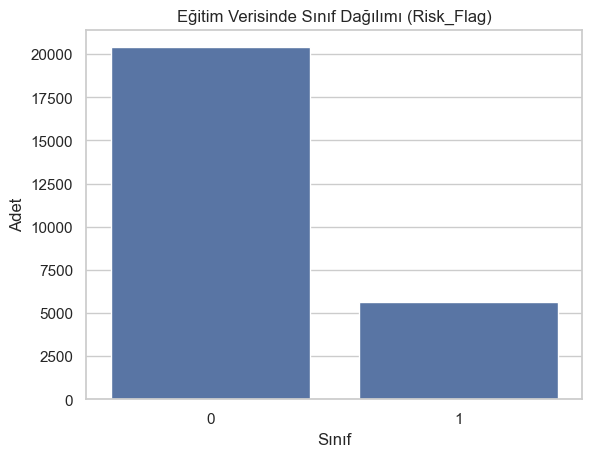

loan_status
0    0.782727
1    0.217273
Name: proportion, dtype: float64


In [15]:
sns.countplot(x=y_train)
plt.title("Eğitim Verisinde Sınıf Dağılımı (Risk_Flag)")
plt.xlabel("Sınıf")
plt.ylabel("Adet")
plt.show()

print(y_train.value_counts(normalize=True))

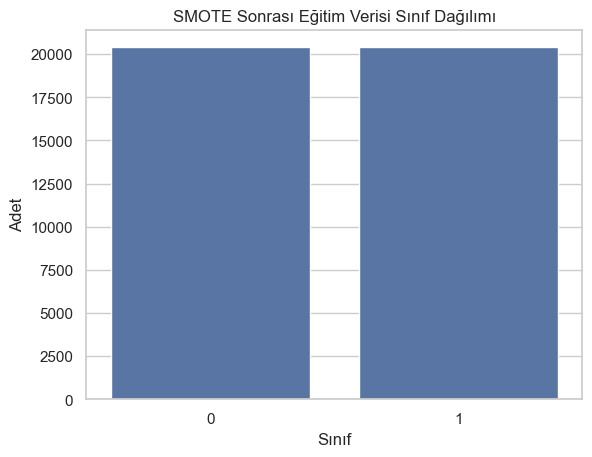

loan_status
0    0.5
1    0.5
Name: proportion, dtype: float64


In [16]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Yeni dağılımı göster
sns.countplot(x=y_train_smote)
plt.title("SMOTE Sonrası Eğitim Verisi Sınıf Dağılımı")
plt.xlabel("Sınıf")
plt.ylabel("Adet")
plt.show()

print(y_train_smote.value_counts(normalize=True))

In [17]:
log_reg_default = LogisticRegression(max_iter=1000)
log_reg_default.fit(X_train, y_train)
y_pred_default = log_reg_default.predict(X_test)
y_proba_default = log_reg_default.predict_proba(X_test)[:, 1]

# Performans metrikleri
f1_default = f1_score(y_test, y_pred_default)
acc_default = accuracy_score(y_test, y_pred_default)
roc_auc_default = roc_auc_score(y_test, y_proba_default)

print("=== Default Logistic Regression ===")
print(classification_report(y_test, y_pred_default))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_default))
print("ROC AUC Score:", roc_auc_default)

=== Default Logistic Regression ===
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      5072
           1       0.73      0.49      0.58      1445

    accuracy                           0.85      6517
   macro avg       0.80      0.72      0.74      6517
weighted avg       0.84      0.85      0.83      6517

Confusion Matrix:
 [[4807  265]
 [ 743  702]]
ROC AUC Score: 0.8607487474485062


In [18]:
log_reg = LogisticRegression(max_iter=1000)
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    "solver" : ['liblinear', 'lbfgs']
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='f1')
grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
y_pred_opt = best_lr.predict(X_test)
y_proba_opt = best_lr.predict_proba(X_test)[:, 1]

f1_opt = f1_score(y_test, y_pred_opt)
acc_opt = accuracy_score(y_test, y_pred_opt)
roc_auc_opt = roc_auc_score(y_test, y_proba_opt)

print("\n=== Optimized Logistic Regression ===")
print("Best Params:", grid_lr.best_params_)
print(classification_report(y_test, y_pred_opt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_opt))
print("ROC AUC Score:", roc_auc_opt)


=== Optimized Logistic Regression ===
Best Params: {'C': 100, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      5072
           1       0.72      0.49      0.58      1445

    accuracy                           0.85      6517
   macro avg       0.80      0.72      0.74      6517
weighted avg       0.84      0.85      0.83      6517

Confusion Matrix:
 [[4802  270]
 [ 738  707]]
ROC AUC Score: 0.8607900898344121


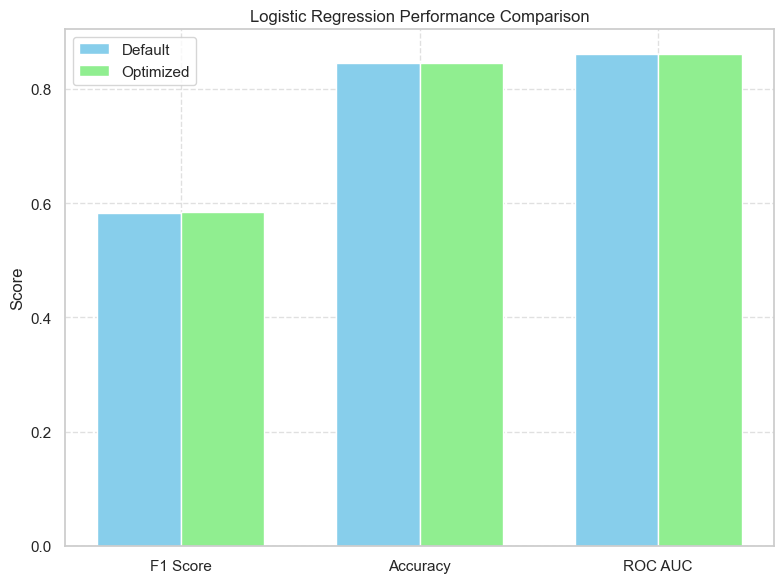

In [19]:
metrics = ['F1 Score', 'Accuracy', 'ROC AUC']
default_scores = [f1_default, acc_default, roc_auc_default]
opt_scores = [f1_opt, acc_opt, roc_auc_opt]

x = range(len(metrics))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x, default_scores, width=width, label='Default', color='skyblue')
plt.bar([i + width for i in x], opt_scores, width=width, label='Optimized', color='lightgreen')
plt.xticks([i + width/2 for i in x], metrics)
plt.ylabel("Score")
plt.title("Logistic Regression Performance Comparison")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [20]:
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train, y_train)

y_pred_rf_default = rf_default.predict(X_test)
y_proba_rf_default = rf_default.predict_proba(X_test)[:, 1]

f1_rf_default = f1_score(y_test, y_pred_rf_default)
acc_rf_default = accuracy_score(y_test, y_pred_rf_default)
roc_auc_rf_default = roc_auc_score(y_test, y_proba_rf_default)

print("=== Default Random Forest ===")
print(classification_report(y_test, y_pred_rf_default))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_default))
print("ROC AUC Score:", roc_auc_rf_default)

=== Default Random Forest ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5072
           1       0.96      0.72      0.83      1445

    accuracy                           0.93      6517
   macro avg       0.94      0.86      0.89      6517
weighted avg       0.93      0.93      0.93      6517

Confusion Matrix:
 [[5027   45]
 [ 398 1047]]
ROC AUC Score: 0.9353185410367524


In [21]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy')
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf_opt = best_rf.predict(X_test)
y_proba_rf_opt = best_rf.predict_proba(X_test)[:, 1]

f1_rf_opt = f1_score(y_test, y_pred_rf_opt)
acc_rf_opt = accuracy_score(y_test, y_pred_rf_opt)
roc_auc_rf_opt = roc_auc_score(y_test, y_proba_rf_opt)

print("\n=== Optimized Random Forest ===")
print("Best Params:", grid_rf.best_params_)
print(classification_report(y_test, y_pred_rf_opt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_opt))
print("ROC AUC Score:", roc_auc_rf_opt)


=== Optimized Random Forest ===
Best Params: {'max_depth': None, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5072
           1       0.96      0.72      0.83      1445

    accuracy                           0.93      6517
   macro avg       0.94      0.86      0.89      6517
weighted avg       0.93      0.93      0.93      6517

Confusion Matrix:
 [[5026   46]
 [ 398 1047]]
ROC AUC Score: 0.9384894201696264


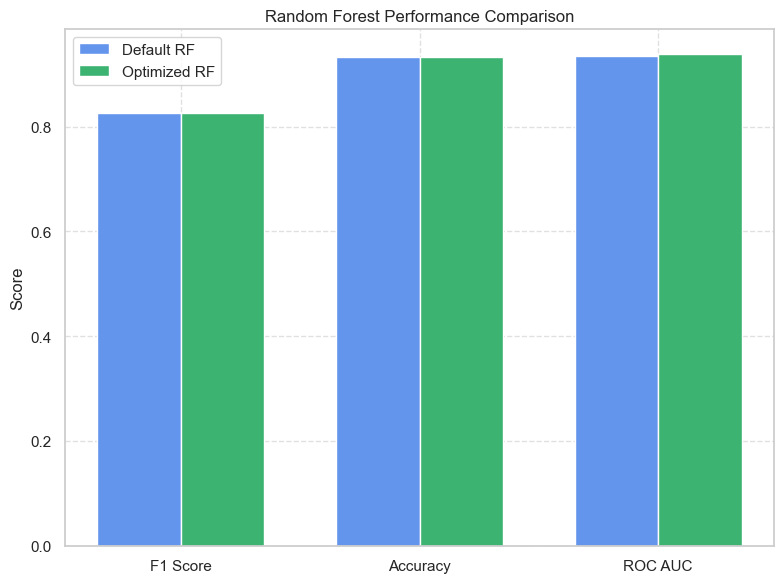

In [22]:
metrics = ['F1 Score', 'Accuracy', 'ROC AUC']
default_scores = [f1_rf_default, acc_rf_default, roc_auc_rf_default]
opt_scores = [f1_rf_opt, acc_rf_opt, roc_auc_rf_opt]

x = range(len(metrics))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x, default_scores, width=width, label='Default RF', color='cornflowerblue')
plt.bar([i + width for i in x], opt_scores, width=width, label='Optimized RF', color='mediumseagreen')
plt.xticks([i + width / 2 for i in x], metrics)
plt.ylabel("Score")
plt.title("Random Forest Performance Comparison")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [23]:
xgb_default = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_default.fit(X_train, y_train)

y_pred_xgb_default = xgb_default.predict(X_test)
y_proba_xgb_default = xgb_default.predict_proba(X_test)[:, 1]

f1_xgb_default = f1_score(y_test, y_pred_xgb_default)
acc_xgb_default = accuracy_score(y_test, y_pred_xgb_default)
roc_auc_xgb_default = roc_auc_score(y_test, y_proba_xgb_default)

print("=== Default XGBoost ===")
print(classification_report(y_test, y_pred_xgb_default))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_default))
print("ROC AUC Score:", roc_auc_xgb_default)

=== Default XGBoost ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5072
           1       0.95      0.74      0.83      1445

    accuracy                           0.93      6517
   macro avg       0.94      0.86      0.89      6517
weighted avg       0.93      0.93      0.93      6517

Confusion Matrix:
 [[5017   55]
 [ 380 1065]]
ROC AUC Score: 0.9516425070677743


In [24]:
param_grid_xgb = {
    'n_estimators': [100, 200,300],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='accuracy')
grid_xgb.fit(X_train, y_train)

best_xgb = grid_xgb.best_estimator_
y_pred_xgb_opt = best_xgb.predict(X_test)
y_proba_xgb_opt = best_xgb.predict_proba(X_test)[:, 1]

f1_xgb_opt = f1_score(y_test, y_pred_xgb_opt)
acc_xgb_opt = accuracy_score(y_test, y_pred_xgb_opt)
roc_auc_xgb_opt = roc_auc_score(y_test, y_proba_xgb_opt)

print("\n=== Optimized XGBoost ===")
print("Best Params:", grid_xgb.best_params_)
print(classification_report(y_test, y_pred_xgb_opt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_opt))
print("ROC AUC Score:", roc_auc_xgb_opt)


=== Optimized XGBoost ===
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5072
           1       0.97      0.73      0.84      1445

    accuracy                           0.94      6517
   macro avg       0.95      0.86      0.90      6517
weighted avg       0.94      0.94      0.93      6517

Confusion Matrix:
 [[5039   33]
 [ 384 1061]]
ROC AUC Score: 0.9513262309934181


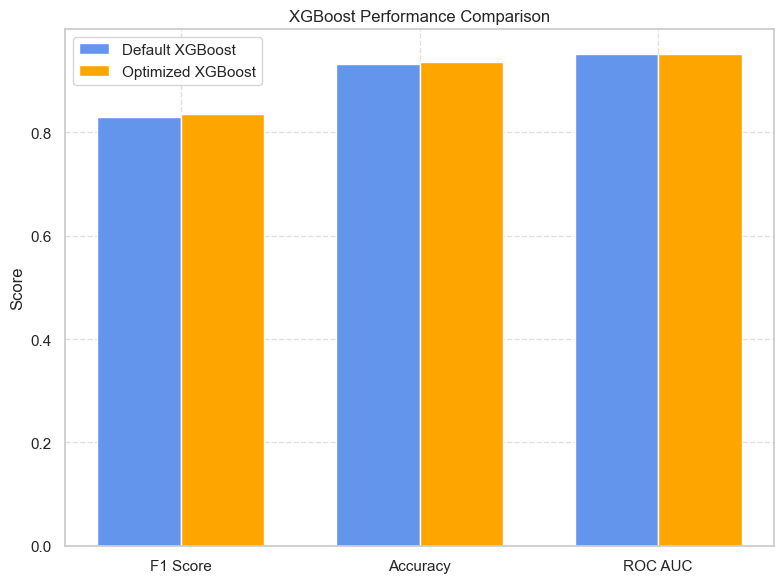

In [25]:
metrics = ['F1 Score', 'Accuracy', 'ROC AUC']
default_scores = [f1_xgb_default, acc_xgb_default, roc_auc_xgb_default]
opt_scores = [f1_xgb_opt, acc_xgb_opt, roc_auc_xgb_opt]

x = range(len(metrics))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x, default_scores, width=width, label='Default XGBoost', color='cornflowerblue')
plt.bar([i + width for i in x], opt_scores, width=width, label='Optimized XGBoost', color='orange')
plt.xticks([i + width / 2 for i in x], metrics)
plt.ylabel("Score")
plt.title("XGBoost Performance Comparison")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Modellerin Karşılaştırılması

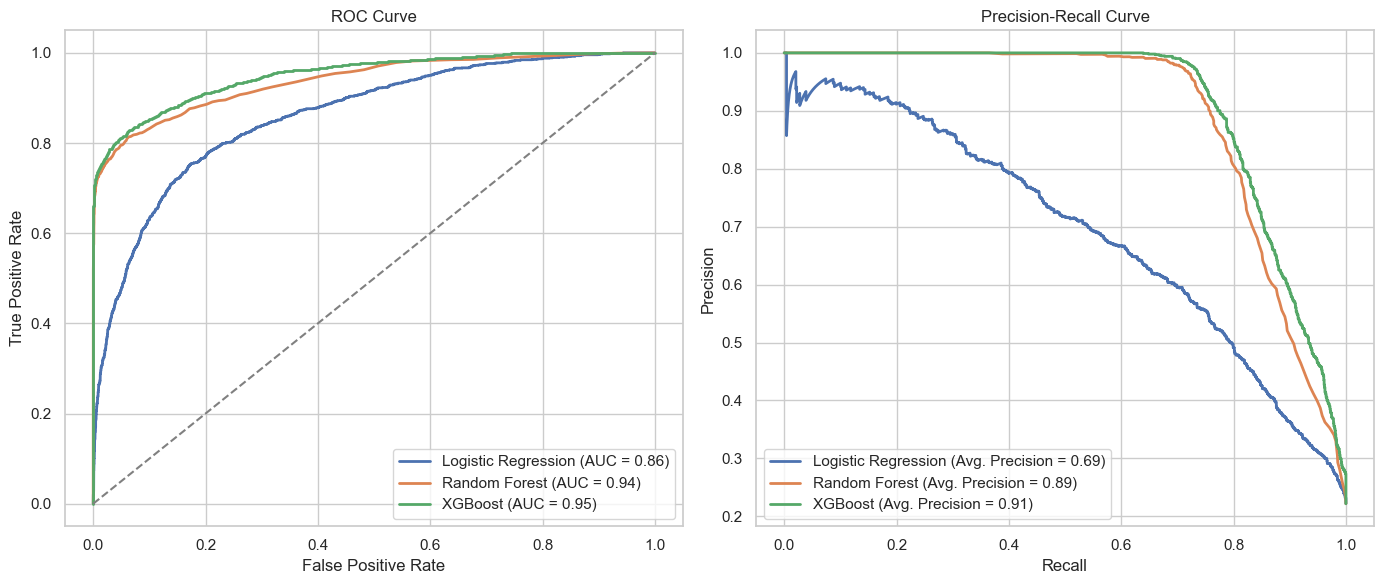

In [26]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

models = {
    "Logistic Regression": best_lr,
    "Random Forest": best_rf,
    "XGBoost": best_xgb
}

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, lw=2, label=f'{name} (Avg. Precision = {avg_precision:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

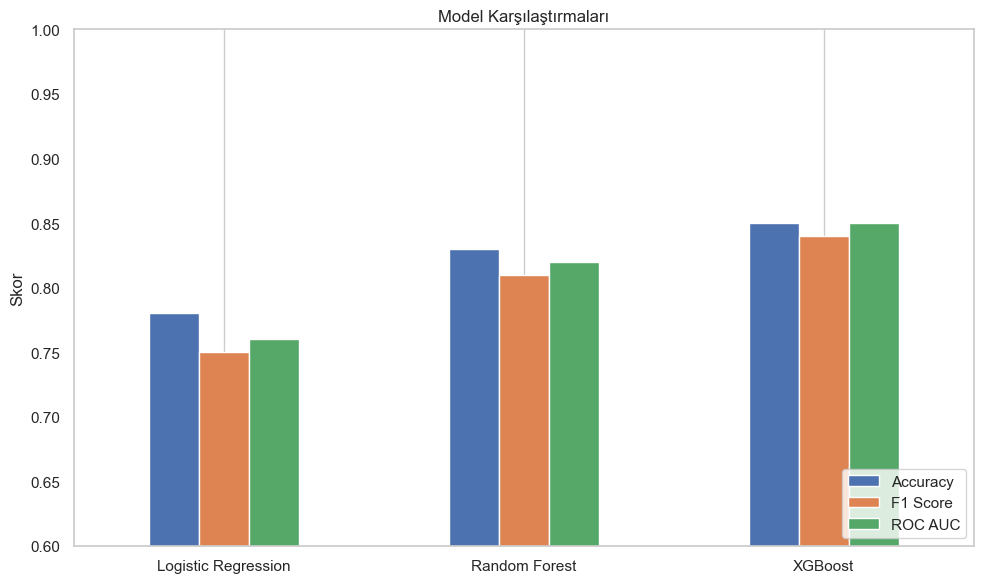

In [27]:
# Örnek karşılaştırma için sonuçlar sözlüğü
results = {
    'Logistic Regression': [0.78, 0.75, 0.76],
    'Random Forest': [0.83, 0.81, 0.82],
    'XGBoost': [0.85, 0.84, 0.85]
}
import pandas as pd
df_results = pd.DataFrame(results, index=['Accuracy', 'F1 Score', 'ROC AUC']).T

df_results.plot(kind='bar', figsize=(10,6))
plt.title('Model Karşılaştırmaları')
plt.ylabel('Skor')
plt.xticks(rotation=0)
plt.ylim(0.6, 1)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

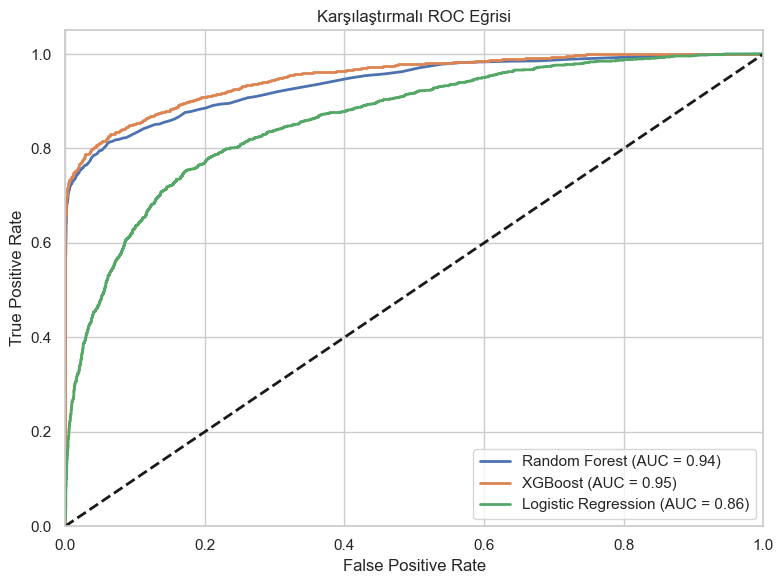

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Tüm modellerin ROC eğrisi karşılaştırması
plt.figure(figsize=(8, 6))

models = {
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
    "Logistic Regression": best_lr
}

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Karşılaştırmalı ROC Eğrisi')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Modellerin Kaydedilmesi

In [29]:
import joblib

best_model_to_save = best_xgb

model_save_path = 'best_model.pkl'
joblib.dump(best_model_to_save, model_save_path)
print(f"Model '{model_save_path}' başarıyla kaydedildi!")

scaler_save_path = 'scaler.pkl'
joblib.dump(scaler, scaler_save_path)
print(f"Scaler '{scaler_save_path}' başarıyla kaydedildi!")

feature_columns_save_path = 'feature_columns.pkl'
joblib.dump(X_train.columns.tolist(), feature_columns_save_path)
print(f"Özellik sütunları '{feature_columns_save_path}' başarıyla kaydedildi!")

Model 'best_model.pkl' başarıyla kaydedildi!
Scaler 'scaler.pkl' başarıyla kaydedildi!
Özellik sütunları 'feature_columns.pkl' başarıyla kaydedildi!
